In [3]:
import sqlite3
import pandas as pd
import json
import os
from pathlib import Path

from tqdm import tqdm
from IPython.display import HTML, display
from PIL import Image
from sklearn.model_selection import train_test_split
import pickle
from torch.utils.data import DataLoader
from torchvision import transforms

from db import *
import torax_detection
import segmentation
from segmentation_train import *
import ontology

In [5]:
run_observations()

df_study_patient_data, df_study_instances, df_study_report  = get_tables_df()

df = create_dataset()
display(df.head(5))

✅ Each study_id has exactly one file_name.
Is study_id unique in df_study_patient_data? True
Is study_id unique in df_study_instances (after grouping)? True
Is study_id unique in df_study_report (after grouping)? True
N study_id without respective instance_id: 221
N file_name that doesn't exist: 21
Available body_parts
{'SPINE LUMBAR', 'TÓRAX', 'TORAX', 'CSPINE', 'LSPINE', 'PELVIS', 'Pectoral', 'ABDOMEN', 'L SPINE', 'NECK', 'TORAX TORAX LATERAL', 'COLUMNA COLUMNA-L/S AP', 'COLUMNA COLUMNA-L/S LATERAL', 'HEAD', 'DEFAULT', 'SHOULDER', 'L/S-SPINE', 'TORAX TORAX PA', 'COLUMNA', 'BREAST', 'PNS', 'ANGIO', 'Senos Paranasales', 'COL. LUMBAR', 'OTHER', 'L-SPINE', 'THORAX', 'CHEST'}


,study_id,body_parts,modalities,patient_age,patient_gender,file_name,instance_ids,instance_measurement_data,report_values,report_ids
0,003b88ed-bdd5-4bac-89b2-c170d9418d75,LSPINE,DX,37,M,80D1627D,[f450b733-2665-4c5a-b640-667bf383c1f3],"[[{'ctr': 85.73, 'uuid': 'e6c3a30d-5786-4297-a...",[<p><strong>Descripci&oacute;n del procedimien...,[0f611a3f-9619-4e1a-aef2-b61603d0a458]
1,0084943c-8a11-467d-b1f4-2ff0c0d8aeff,"ABDOMEN,OTHER",CT,68,F,D4E52883,[9d24fc05-0a41-4a94-9d59-42c5f806d354],"[[{'ctr': 66.54, 'uuid': '40a20730-ef63-49e4-a...",[<p><strong>TOMOGRAFIA DE TORAX Y ABDOMEN.</st...,[1d187804-8c64-4fe3-86f0-4894a9ae2701]
2,00b5f7cf-1ef4-43bc-a8b8-0f36a15f4b5e,CHEST,CR,67,F,9988B8C4,[251fd155-c42a-4603-a8a5-e48e00e381d1],"[[{'ctr': 46.16, 'uuid': 'a0ca5b2d-0fa4-4aee-9...",[<p><strong>T&eacute;cnica.</strong></p> <p>Te...,[45196608-c2dc-4b16-ac9e-78ecdb4d6c6e]
4,00f65e49-5127-4149-9af2-f06a97d3e84a,CHEST,CR,,F,E138AA87,[260a442c-8ff3-4c9f-bd2d-7ab7b5653d2d],"[[{'ctr': 52.28, 'uuid': '8c11a4e8-953d-4091-9...",[<div>T&eacute;cnica: Imagen digital en proyec...,[19030e94-81e2-4245-9398-5c152c80bf03]
7,026ba6b1-8231-4432-ba18-d7e3a9ca0992,CHEST,CR,37,M,35236841,[75e6701f-24d4-45eb-aa2f-0264361bae3c],"[[{'ctr': 42.9, 'uuid': 'a439cffc-b8a2-47c0-86...","[<div style=""text-align: justify;""><span style...",[ad19b6c0-0093-4697-85a4-f21014cfc4d9]


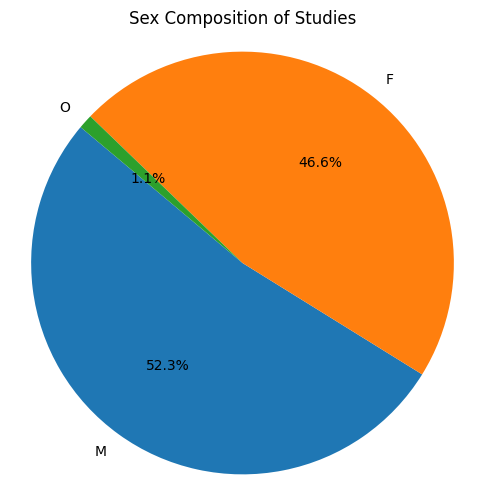

In [18]:
# Plotting the pie chart for gender composition
gender_counts = df_study_patient_data['patient_gender'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sex Composition of Studies')
plt.axis('equal')
plt.show()

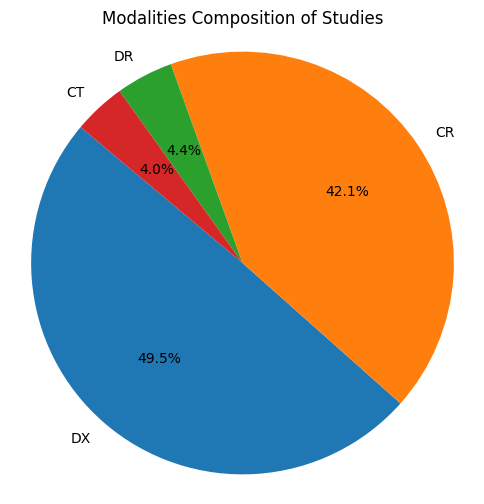

In [20]:
# Plotting the pie chart for gender composition
modalities_counts = df_study_patient_data['modalities'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(modalities_counts, labels=modalities_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Modalities Composition of Studies')
plt.axis('equal')
plt.show()

<function matplotlib.pyplot.grid(visible: 'bool | None' = None, which: "Literal['major', 'minor', 'both']" = 'major', axis: "Literal['both', 'x', 'y']" = 'both', **kwargs) -> 'None'>

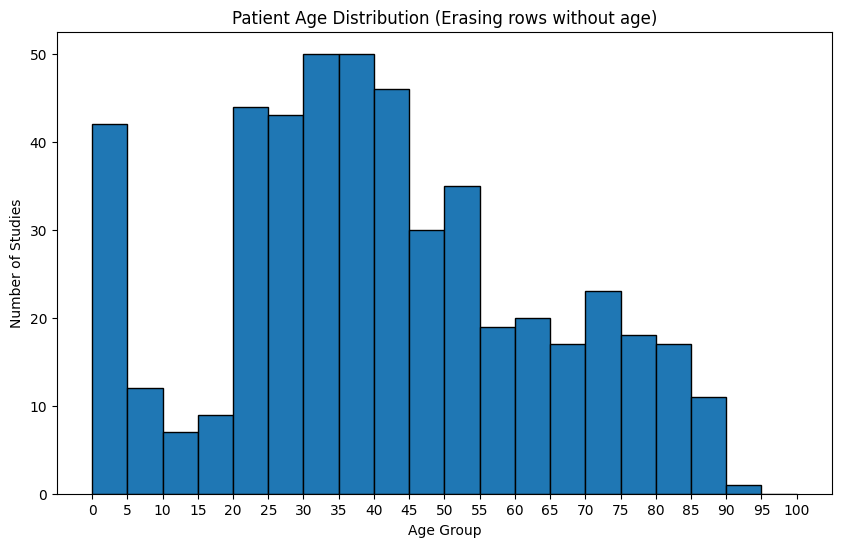

In [24]:
# Convert patient_age to numeric, forcing errors to NaN
df_study_patient_data['patient_age'] = pd.to_numeric(df_study_patient_data['patient_age'], errors='coerce')

# Drop any rows where patient_age is NaN (i.e., could not be converted to a number)
df_cleaned = df_study_patient_data.dropna(subset=['patient_age'])

# Plot the histogram again with cleaned data
bins = range(0, 101, 5)
plt.figure(figsize=(10, 6))
plt.hist(df_cleaned['patient_age'], bins=bins, edgecolor='black')
plt.title('Patient Age Distribution (Erasing rows without age)')
plt.xlabel('Age Group')
plt.ylabel('Number of Studies')
plt.xticks(bins)
plt.grid

In [ ]:
torax_detection.train_torax_classifier()

Using MPS on Apple Silicon
Using MPS on Apple Silicon
Using MPS on Apple Silicon
Using MPS on Apple Silicon
Using MPS on Apple Silicon
Using MPS on Apple Silicon


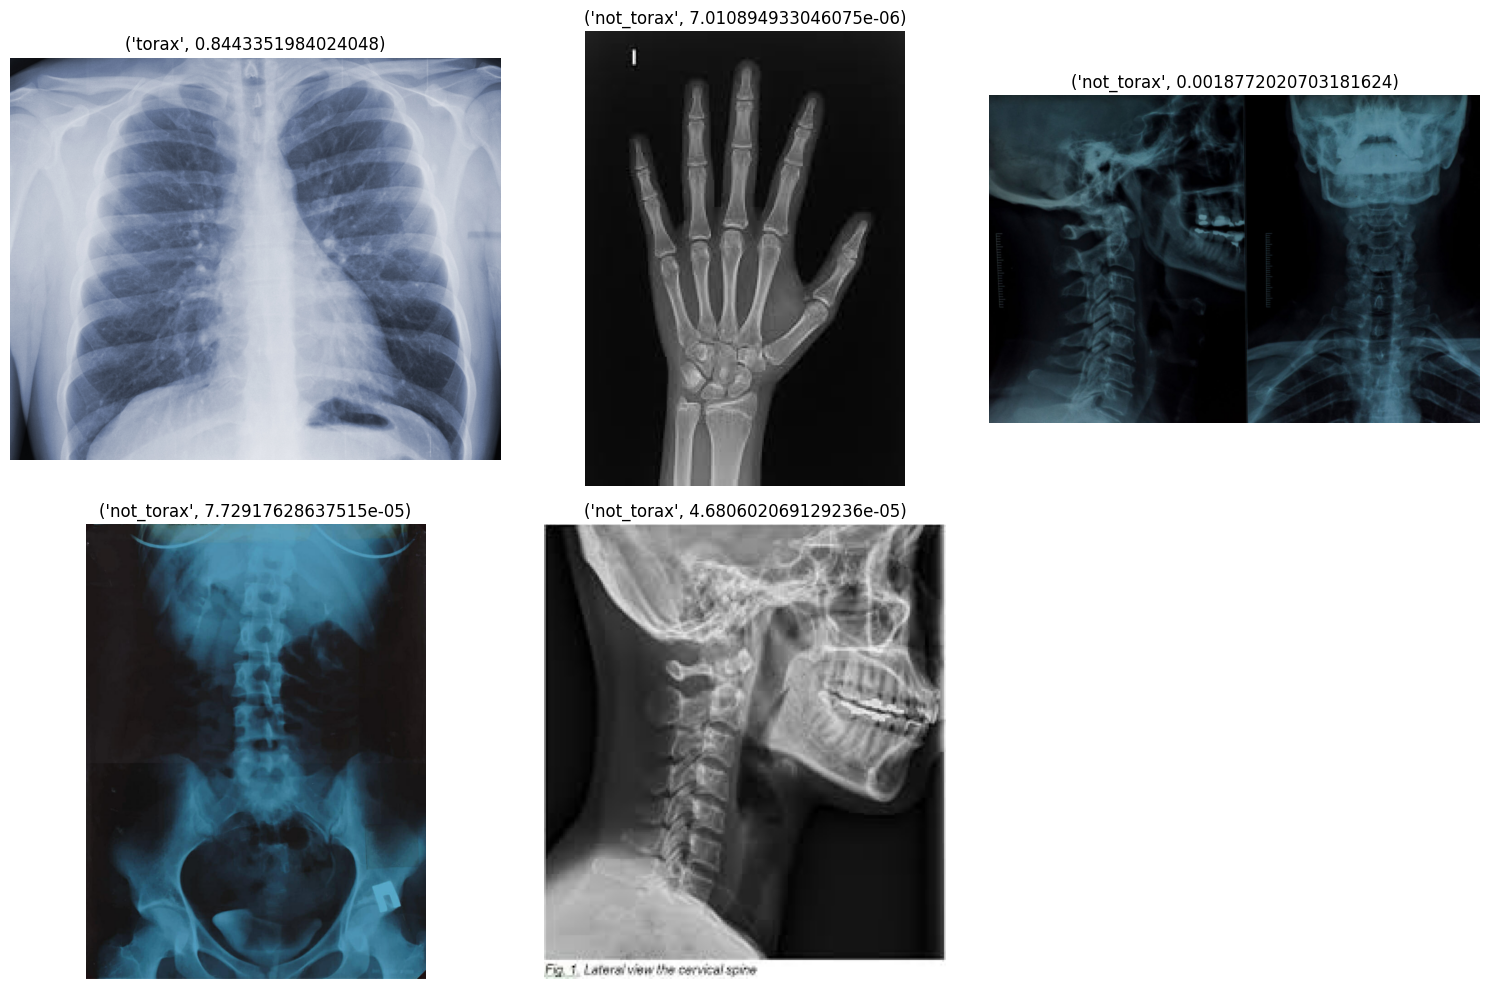

In [5]:
images_to_test_classifier = ["data/test_classifier/a.jpg",
                             "data/test_classifier/b.jpeg",
                             "data/test_classifier/c.jpg",
                             "data/test_classifier/d.jpg",
                             "data/test_classifier/e.jpeg"]

model = torax_detection.load_model("models/torax_detector_model.pth")

# Set number of columns for the grid
cols = 3
rows = (len(images_to_test_classifier) + cols - 1) // cols  # Ceiling division

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  # Flatten in case of more than 1 row

for i, image_file in enumerate(images_to_test_classifier):
    image = Image.open(image_file).convert("RGB")
    prediction = torax_detection.predict_image(image_file, model)
    
    axes[i].imshow(image)
    axes[i].set_title(str(prediction), fontsize=12)
    axes[i].axis("off")

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


<function matplotlib.pyplot.grid(visible: 'bool | None' = None, which: "Literal['major', 'minor', 'both']" = 'major', axis: "Literal['both', 'x', 'y']" = 'both', **kwargs) -> 'None'>

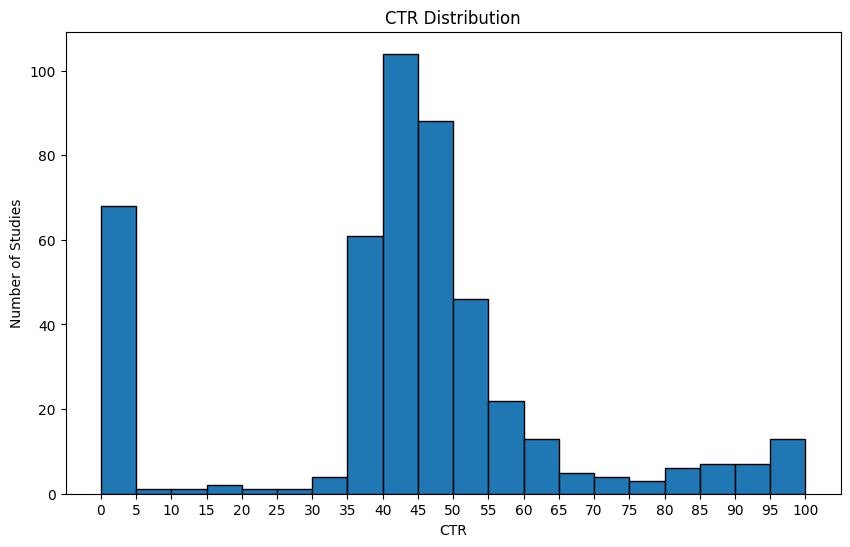

In [38]:
def extract_ctr(md):
    return json.loads(md)[0]['ctr']
ctr = df_study_instances.measurement_data.apply(extract_ctr)

# Plot the histogram again with cleaned data
bins = range(0,101, 5)
plt.figure(figsize=(10, 6))
plt.hist(ctr, bins=bins, edgecolor='black')
plt.title('CTR Distribution')
plt.xlabel('CTR')
plt.ylabel('Number of Studies')
plt.xticks(bins)
plt.grid

In [30]:
df = create_dataset()
df.reset_index(drop=True, inplace=True)

ont = ontology.get_ontology(df)
df['ontology'] = pd.Series(ont)

Ontology loaded from file.
Error parsing: tejido_mamario.fibroglandular_tipo = "B"
Error parsing: hemitorax.expansion = "simetrica"
Error parsing: cuerpos_vertebrales.altura = "adecuada"
Error parsing: cuerpos_vertebrales.morfologia = "normal"
Error parsing: pediculos.morfologia = "conservada"
Error parsing: apofisis.transversas = "conservada"
Error parsing: apofisis.espinosas = "conservada"
Error parsing: facetas_articulares.superiores_morfologia = "conservada"
Error parsing: facetas_articulares.inferiores_morfologia = "conservada"
Error parsing: espacios_intersomaticos.altura = "normal"
Error parsing: corazon.situacion = "habitual"


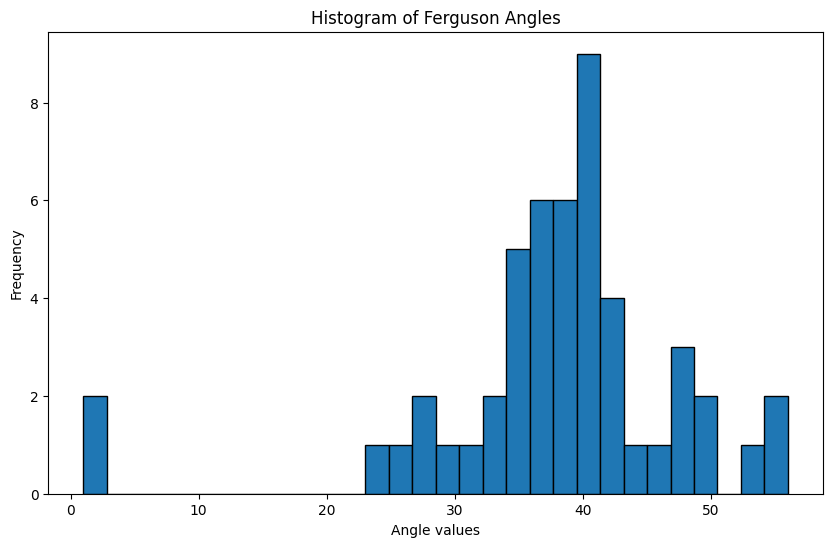

In [33]:
def get_ferguson_angle(ontology):
    if not isinstance(ontology,list):
        return None
    for xs in ontology:
        for k,v in xs:
            if 'ferguson' in k:
                return v
    return None

ferguson_angles = df['ontology'].apply(get_ferguson_angle)
ferguson_angles = ferguson_angles[~ferguson_angles.isna()]

plt.figure(figsize=(10, 6))
plt.hist(ferguson_angles, bins=30, edgecolor='black')
plt.xlabel('Angle values')
plt.ylabel('Frequency')
plt.title('Histogram of Ferguson Angles')
plt.show()

In [29]:
def has_escoliosis(ontology):
    if not isinstance(ontology,list):
        return False
    normal, anormal = ontology
    for k,v in anormal:
        if 'escoliosis' in k:
            return True
    return False
        
escoliosis_ids = df[df['ontology'].apply(has_escoliosis)]['study_id']
print(f"{len(escoliosis_ids)} casos con escoliosis:")
print('\n'.join('- '+sid for sid in escoliosis_ids))

14 casos con escoliosis:
- 003b88ed-bdd5-4bac-89b2-c170d9418d75
- 0403dfdd-9ac4-4d6b-86ab-fb3647e90891
- 082ca1b1-a9a2-4c77-9a55-64f06c920f4b
- 0df07efa-1e39-4c57-96cf-eee4a2e16eff
- 1ec28fe0-2868-494b-b129-21caf9a01927
- 21e23158-711c-478a-8429-0ac9caa00484
- 4aa65847-6f5f-4559-8bd0-7482ed01f097
- 5c016336-0d4e-4b7f-aa33-a518f00b0bf4
- 904c8271-12a2-4015-9f62-f5ea97fe2337
- a1e11c71-583e-4620-90eb-ebe901676694
- a225cdb1-ec06-428f-8aa2-f19bf892000a
- b43aeabc-f687-4aa6-976d-489a9ecb8ed2
- daf33fc7-870a-424b-a169-d538f21d2fa2
- f97c2d0e-c063-4b02-adbb-ca67e154f2b5


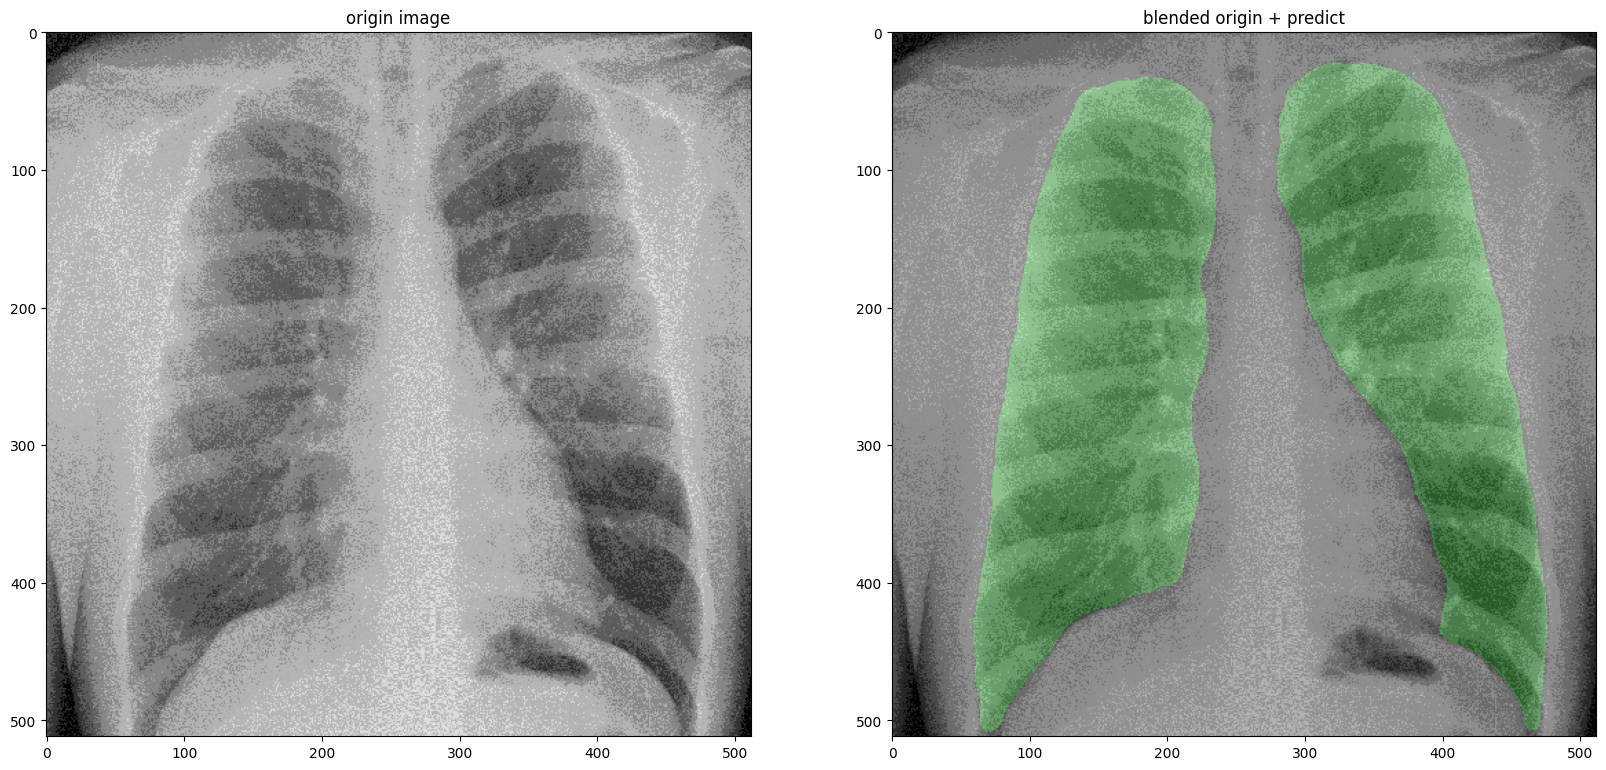

In [62]:
origin_filename = "data/test_classifier/a.jpg"

origin = Image.open(origin_filename).convert("P")
origin = torchvision.transforms.functional.resize(origin, (512, 512))
origin = torchvision.transforms.functional.to_tensor(origin) - 0.5

with torch.no_grad():
    origin = torch.stack([origin])
    origin = origin.to(device)
    out = unet(origin)
    softmax = torch.nn.functional.log_softmax(out, dim=1)
    out = torch.argmax(softmax, dim=1)
    
    origin = origin[0].to("cpu")
    out = out[0].to("cpu")

plt.figure(figsize=(20, 10))

pil_origin = torchvision.transforms.functional.to_pil_image(origin + 0.5).convert("RGB")

plt.subplot(1, 2, 1)
plt.title("origin image")
plt.imshow(np.array(pil_origin))

plt.subplot(1, 2, 2)
plt.title("blended origin + predict")
plt.imshow(np.array(blend(origin, out)));